In [1]:
# to check, whether the results depend on shuffling
# test on the smallest set
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess
import os
import random
import shutil
from collections import Counter

DATASET_DIR = "../tests/input_files/test_100_50_25/"
TEMP_DIR = "temp"
DATASET_FILES = os.listdir(DATASET_DIR)
ANSWER = 25
STRNUM = 50
STRLEN = 100
os.mkdir(TEMP_DIR) if not os.path.isdir(TEMP_DIR) else None

In [2]:
# create shuffled files
to_check = random.choice(DATASET_FILES)
to_check_path = os.path.join(DATASET_DIR, to_check)
replicate_min = {}  # number of replicate -> minimal answer

rep_files = []
shuffle_cmd_templ = "../shuffle_input.py " + to_check_path + " {} -o {} -c"
for i in range(1, STRNUM):
    out_file = os.path.join(TEMP_DIR, "rep_{}.txt".format(i))
    shuffle_cmd = shuffle_cmd_templ.format(i, out_file)
    subprocess.call(shuffle_cmd, shell=True)
    rep_files.append(out_file)

In [3]:
# call CSP for each file
# a long stage
csp_cmd_templ = "../CSP {} {}"

for num, rep in enumerate(rep_files):
    # get the minimal answer for each
    for i in range(ANSWER, STRLEN):
        csp_cmd = csp_cmd_templ.format(rep, i)
        csp_out = subprocess.check_output(csp_cmd, shell=True).decode("utf-8").split("\n")[1]
        if csp_out == "False":
            continue
        # write the result then
        replicate_min[num] = i
        break

In [4]:
# visualize it
min_times = Counter()
for v in replicate_min.values():
    min_times[v] += 1
times_sort = sorted(min_times.keys())
for t in range(times_sort[0], times_sort[-1] + 1):
    app_ = min_times.get(t) if min_times.get(t) else 0
    print("{}:\n{}".format(t, "*" * app_))
# defenitely, algorithm is init string - dependent

33:
*
34:
****
35:
********
36:
**************
37:
*************
38:
*******
39:
**


In [20]:
# maybe get some statistics?
rep_zeros = {}
rep_k = {}
nums = range(len(rep_files))
maxes = []
mins = []
ks = []
deltas = []
aves = []

for num, rep in enumerate(rep_files):
    # get the minimal answer for each
    f = open(rep, "r")
    lines = [l[:-1] for l in f.readlines()]
    f.close()
    
    k = replicate_min[num]
    print("\nReplicate num {} K: {}".format(num, k))
    zeros = sorted([line.count("0") for line in lines])
    rep_zeros[num] = zeros[1:]
    rep_k[num] = k
    ks.append(k)
    max_zeros = zeros[-1]
    min_zeros = zeros[1]  # because in 0 -> 0
    maxes.append(max_zeros)
    mins.append(min_zeros)
    deltas.append(delta)
    delta = max_zeros - min_zeros
    ave = 
    print("Min zeros: {}; Max: {}, D: {}".format(min_zeros, max_zeros, delta))


Replicate num 0 K: 35
Min zeros: 24; Max: 44, D: 20

Replicate num 1 K: 34
Min zeros: 30; Max: 48, D: 18

Replicate num 2 K: 38
Min zeros: 30; Max: 44, D: 14

Replicate num 3 K: 38
Min zeros: 32; Max: 46, D: 14

Replicate num 4 K: 36
Min zeros: 28; Max: 46, D: 18

Replicate num 5 K: 37
Min zeros: 30; Max: 44, D: 14

Replicate num 6 K: 37
Min zeros: 30; Max: 46, D: 16

Replicate num 7 K: 36
Min zeros: 28; Max: 46, D: 18

Replicate num 8 K: 37
Min zeros: 30; Max: 46, D: 16

Replicate num 9 K: 37
Min zeros: 30; Max: 42, D: 12

Replicate num 10 K: 34
Min zeros: 30; Max: 46, D: 16

Replicate num 11 K: 36
Min zeros: 28; Max: 46, D: 18

Replicate num 12 K: 36
Min zeros: 30; Max: 46, D: 16

Replicate num 13 K: 35
Min zeros: 32; Max: 44, D: 12

Replicate num 14 K: 37
Min zeros: 26; Max: 44, D: 18

Replicate num 15 K: 38
Min zeros: 30; Max: 44, D: 14

Replicate num 16 K: 36
Min zeros: 28; Max: 44, D: 16

Replicate num 17 K: 36
Min zeros: 28; Max: 46, D: 18

Replicate num 18 K: 33
Min zeros: 28;

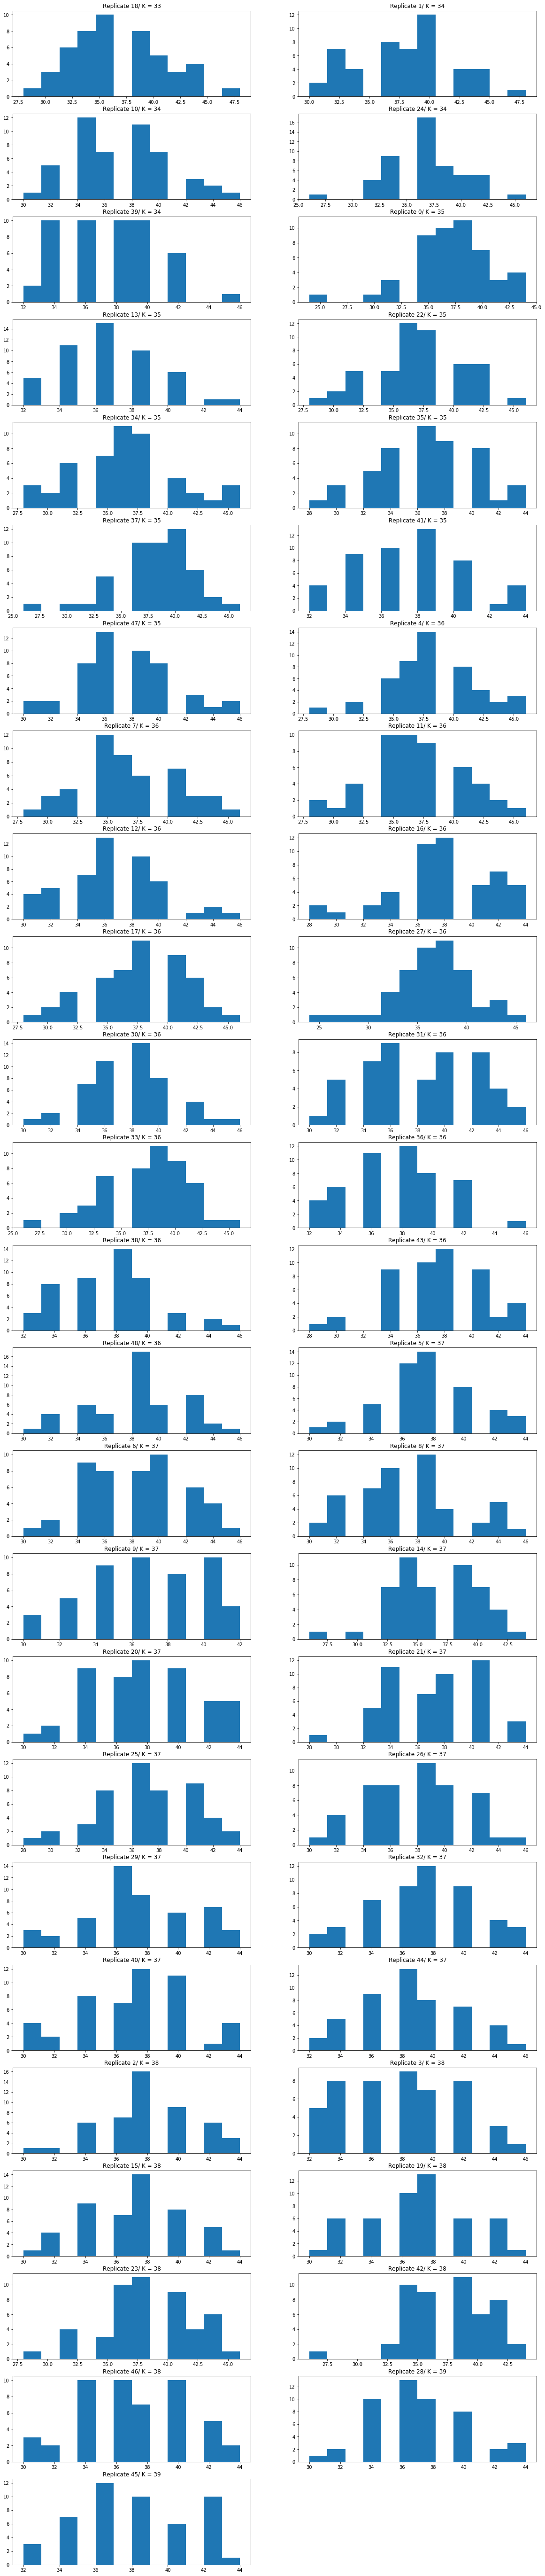

In [12]:
# visualize zero distrs
# maybe it is the key?
fig=plt.figure(figsize=(20, 100))
rep_num = len(rep_files)
columns = 2
rows = (rep_num // 2) + (rep_num % 2)
zeros_num = len(rep_zeros[0])
bins = zeros_num // 4
keys_ord = sorted([k for k in rep_k.keys()], key=lambda x: rep_k[x])

for i in range(1, rep_num + 1):
    r_i = keys_ord[i - 1]
    title = "Replicate {}/ K = {}".format(r_i, rep_k[r_i])
    ax1 = fig.add_subplot(rows, columns, i)
    plt.hist(rep_zeros[r_i], bins=bins)
    ax1.title.set_text(title)


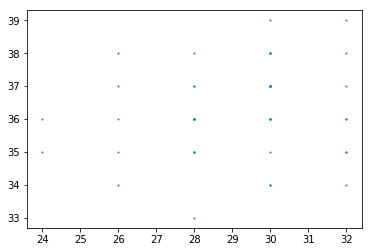

In [22]:
# another visualisation?
plt.scatter(mins, ks, s=1)

In [ ]:
shutil.rmtree(TEMP_DIR) if os.path.isdir(TEMP_DIR) else None